### Introduction

This notebook addresses the problem of heart disease prediction. The dataset used for this analysis was generated synthetically by the author. To enhance the dataset's size and complexity, it has been expanded to 500 data points. The Random Forest Classifier is employed to build a prediction model for heart disease. The dataset is split into training and test sets, with a 50/50 ratio, resulting in 250 samples for training and 250 samples for testing. The prediction model's accuracy is assessed by running it twice, providing insights into its performance.

In [1]:
import numpy as np
import scipy.stats as ss
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

# Assigns different outcomes to Body Mass Index features, classified by range criteria

def calc_bmi_p(weight, height):
            outcomes = [0,1]
            probs = [(0.6, 0.4), (0.85, 0.15),(0.9,0.1)]
            chol_prob, circ_prob = (0, 0)
            bmi = weight/((height/100)**2)
            if bmi>28:
                chol_prob, circ_prob = np.random.choice(outcomes, p = probs[0], size = 2)
            elif bmi>32:
                chol_prob, circ_prob = np.random.choice(outcomes, p = probs[1], size = 2)
            elif bmi > 38:
                chol_prob, circ_prob = np.random.choice(outcomes, p = probs[2], size = 2)
            return chol_prob, circ_prob


### Synthetic data generator
Generates synthetic data for `n` patients. `X_col` refers to the number of used features, 6 being used in this example. It returns a `np.array` object of `n` x `X_col` dimensions, containing both the data points for the covariates (High Cholesterol, Poor Circulation, Weight, Height, Age) and the outcomes (Heart Disease). The `sd` (standard deviation) parameter in this example is used to add variation to the weight and height variables.

- **High Cholesterol**: Binary variable (0 or 1).
- **Poor Circulation**: Binary variable (0 or 1).
- **Weight**: Weight of the individual in kilograms.
- **Height**: Height of the individual in centimeters.
- **Age**: Age of the individual.
- **Heart Disease**: Binary target variable (0 or 1) indicating the presence or absence of heart disease.

The data generation process is as follows:

- We calculate the probabilities of high cholesterol and poor circulation based on the BMI (Body Mass Index) of each individual.
- We assign probabilities to different BMI ranges, and these probabilities affect the outcomes of high cholesterol and poor circulation.
- Based on the outcomes of high cholesterol and poor circulation, we determine the probability of heart disease.
- We generate random values for these features while considering age, and based on the probabilities, we assign values to high cholesterol, poor circulation, and heart disease.

Afterwards, we create the "md_db.csv" file, containing the synthetically generated `df` data frame of 500 data points.

In [2]:
def synth_gen(n, X_col, sd):
    
    X = np.zeros((n, X_col-1))
    Y = []
    for i in range(n):
        age, weight, height = (np.random.randint(20, 60), 
                               np.random.randint(50,140) + int(ss.norm.rvs(0, sd, 1)), 
                               np.random.randint(155,170) + int(ss.norm.rvs(0, sd, 1)))
        y = 0
        chol_prob, circ_prob = (calc_bmi_p(weight, height))
        if chol_prob + circ_prob == 2 and age>50:
            y = np.random.choice([0,1], p = [0.1 , 0.9], size = 1)[0]
        if chol_prob + circ_prob == 2 and age<50:
            y = np.random.choice([0,1], p = [0.3 , 0.7], size = 1)[0]
        elif chol_prob + circ_prob == 1:
            y = np.random.choice([0,1], p = [0.4 , 0.6], size = 1)[0]
        elif chol_prob + circ_prob == 0:
            y = np.random.choice([0,1], p = [0.7 , 0.3], size = 1)[0]
        x=(chol_prob, circ_prob, weight, height, age)
        Y.append(y)

        for j in range(X_col-1):
            X[i,j]= x[j]
    np.array(Y).reshape(-1,1)
    return np.column_stack((X,Y))

# Generate synthetic data and save it to a CSV file

df = pd.DataFrame(data=synth_gen(500, 6, 1), columns=["High Cholesterol", "Poor Circulation", "Weight", "Height", "Age", "Heart Disease"])
df.to_csv("md_db.csv")
df.head()

,High Cholesterol,Poor Circulation,Weight,Height,Age,Heart Disease
0,1.0,0.0,137.0,161.0,44.0,1.0
1,0.0,1.0,86.0,167.0,20.0,0.0
2,0.0,0.0,52.0,156.0,27.0,0.0
3,0.0,0.0,136.0,164.0,24.0,0.0
4,0.0,0.0,78.0,167.0,46.0,0.0


### Data loading and splitting

We load the synthetic data from the CSV file into a Pandas DataFrame. This DataFrame will be used for model training and evaluation. We then split the data into training and testing sets. In this example, we use a 50-50 train-test split ratio. The training data will be used to train our Random Forest Classifier, while the testing data will be used to evaluate the model's performance.

In [3]:
df = pd.read_csv("md_db.csv")
X = df.drop(columns=["Heart Disease", "Unnamed: 0"])
y = df["Heart Disease"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

### Model initialization, training and cross-validation

We initialize the Random Forest Classifier. This is the machine learning model that we'll use for heart disease prediction. We train the Random Forest model on the training data using the `fit` method. Then, we evaluate the model's accuracy, cross-validation scores, and we plot a confusion matrix for the test set through a heatmap.

Random Forest Accuracy: 0.576
Cross-Validation Scores:
Fold 1: 0.6200
Fold 2: 0.5000
Fold 3: 0.6200
Fold 4: 0.6400
Fold 5: 0.6400
Mean CV Score: 0.6040
Std CV Score: 0.0528
Test Set Accuracy: 0.5760


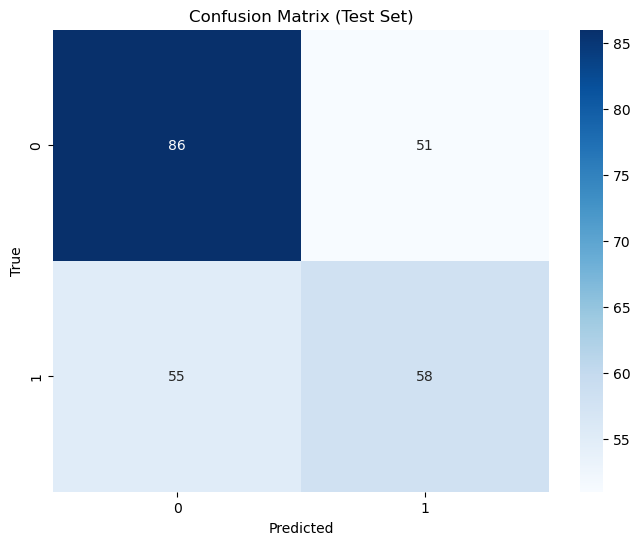

In [4]:
# Initializes the Random Forest Classifier, trains the model
# and makes prediction on the training data

rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

# Calculates accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy}")

# Performs cross-validation on the training set
cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv=5)
print("Cross-Validation Scores:")
for i, score in enumerate(cv_scores, 1):
    print(f"Fold {i}: {score:.4f}")
print(f"Mean CV Score: {np.mean(cv_scores):.4f}")
print(f"Std CV Score: {np.std(cv_scores):.4f}")

# Assuming 'true_labels' contains the true values of "Heart Disease" for the new data
true_labels = y_test

# Calculates accuracy for the test set
test_accuracy = accuracy_score(true_labels, y_pred)
print(f"Test Set Accuracy: {test_accuracy:.4f}")

# Creates and plots confusion matrix for the test set
conf_matrix = confusion_matrix(true_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Test Set)")
plt.show()

### Hyperparameter optimization

This code performs a grid search over a range of hyperparameter values and identifies the best combination.

In [5]:
from sklearn.model_selection import GridSearchCV

# Defines the hyperparameter grid to search over
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Initializes the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Creates a grid search with cross-validation and fits the
# grid search to the training data
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Prints the best hyperparameters found
print("Best Hyperparameters:")
print(grid_search.best_params_)

# Gets the best model
best_rf_model = grid_search.best_estimator_

# Evaluates the best model on the test set
best_rf_model.fit(X_train, y_train)
y_pred_best = best_rf_model.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Test Set Accuracy (Best Model): {accuracy_best:.4f}")


Best Hyperparameters:
{'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Test Set Accuracy (Best Model): 0.6040
